# **Time series data**
- data which is created over a time period

Data Split Method
- **Fixed Partitioning**: split your data into a training period (the first 70% of time steps), a validation period (the next 15% of the time steps) and a testing period (the final 15% of the time steps)
- **Roll-Forward Partitoining**: Start training on the earliest data, gradually increasing as needed. Your validation data are the most recent examples, where as, your test period are the timestamps happening now and into the future.
  - This means your model gets evaluating on a rolling basis as new data flows in.

Type of Time Series
1. Univariate time series — only one parameter through time, such as, video game sales over time.
2. Multivariate time series — multiple parameters through time, such as, birth and death rates.

Application Types
- Anomaly prediction — finding a sample which shouldn't have occurred in a series of other samples over time.
- Forecasting — predicting future events based on past events.
- Analyzing sequences to recognize what called them — predicting what word a soundwave produced based on the timesteps of the wave.

Elements
- **Trend** — An overall direction for data regardless of direction.
- **Seasonality** — A regular change in shape of the data.
- **Autocorrelation** — timesteps which are very similar to previous timesteps but don't appear to have a defined trend. correlation between two values of the same variable at times Xi and Xi+k.
- **Noise** — unpredictable occurrences scattered across time.
    - Many real-world datasets will have some level of each of these.

Forecasting Method
- **Moving average** involves taking a box of values (for example the pat 30 days) and using the mean of these values as the next time step prediction. This eliminates a lot of noise but does not include trend or seasonality.
- **Differencing** involves the studying the time series with no trend or seasonality.
    - You can do this using Series(t) - Series(t-365)

Metrics for evaluating performance
- errors = forecasts - actual
- mse = np.square(error).mean()
- rmse = np.sqrt(mse)
- mae = np.abs(errors).mean()
- mape = np.abs(errors/ x_valid).mean()

Trailing vs Centered Windows
- **trailing**: moving average of present value from t -32, t-1
- **centered**: moving average of past values from t - 1 year - 5 days, t - 1 year + 5 days

    *cented window can be more accurate, but it can't be used to smooth present value due to we do not know the future values.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

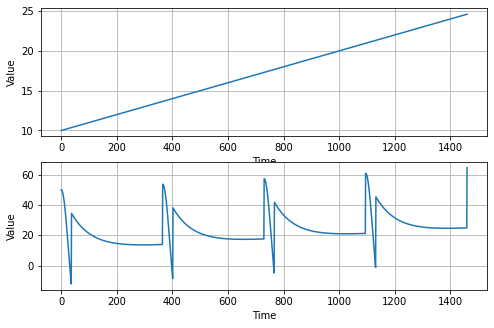

In [ ]:
#Trend Graph
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = baseline + trend(time, slope)

fig =  plt.figure(figsize = (8,8))
ax = fig.add_subplot(311)
plot_series(time, series)

#Trend + Seasonality Graph
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
ax = fig.add_subplot(312)
plot_series(time, series)
plt.show()

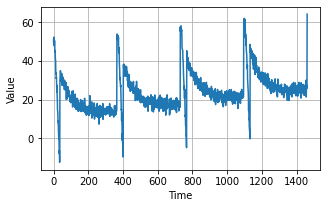

In [ ]:
#Trend + Seaonality + Noise Graph
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Add noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(5,3))
plot_series(time, series)
plt.show()
# Chart as in the screencast. First should have 5 distinctive 'peaks'

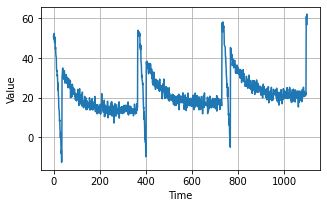

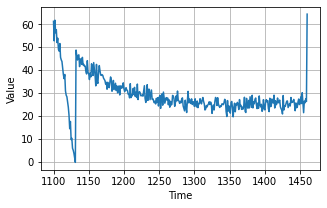

In [ ]:
#Split the series into 2(training period and validation period)
split_time = 1100
train_time = time[:split_time]
train_x = series[:split_time]
valid_time = time[split_time:]
valid_x = series[split_time:]

#Train Data
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
plt.figure(figsize=(5,3))
plot_series(train_time, train_x)
plt.show()

#Validation Data

plt.figure(figsize=(5,3))
plot_series(valid_time, valid_x)
plt.show()

# **Naive Forecast**
Naive is projecting time stepped 1 unit 'after' series.


Mean Squared Error: 19.578304
Mean Absolute Error: 2.6011968 



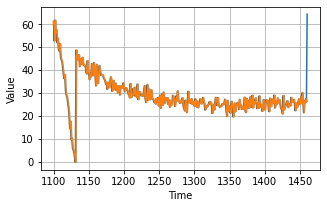

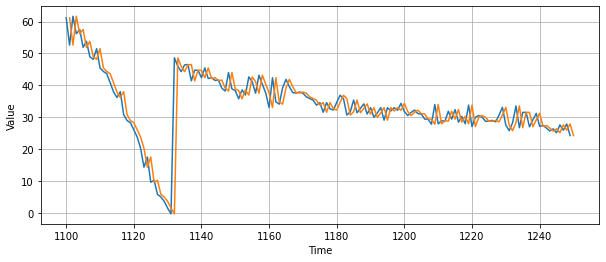

In [ ]:
naive_forecast = series[split_time -1 : -1]

#Regular Plot
plt.figure(figsize=(5,3))
plot_series(valid_time, valid_x) 
plot_series(valid_time, naive_forecast) 

#Zoom in
plt.figure(figsize=(10,4))
plot_series(valid_time, valid_x, start = 0, end = 150)
plot_series(valid_time, naive_forecast, start = 1, end = 151)

#MSE, MAE
print("\nMean Squared Error:",keras.metrics.mean_squared_error(valid_x, naive_forecast).numpy())
print("Mean Absolute Error:",keras.metrics.mean_absolute_error(valid_x,naive_forecast).numpy(),"\n")
#---Chart similar to above, but with forecast overlay
#---Zoom chart, Projections should be time stepped 1 unit 'after' series

# **Moving Average**

- if window_size = 1, it is equivalent to naive forecast.


Mean Squared Error: 65.786224
Mean Absolute Error: 4.3040023 



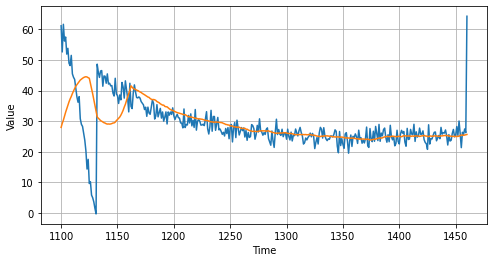

In [ ]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(8,4))
plot_series(valid_time, valid_x)
plot_series(valid_time, moving_avg)

#MSE, MAE
print("\nMean Squared Error:", keras.metrics.mean_squared_error(valid_x, moving_avg).numpy())
print("Mean Absolute Error:", keras.metrics.mean_absolute_error(valid_x, moving_avg).numpy(),"\n")

# **Differing Series**


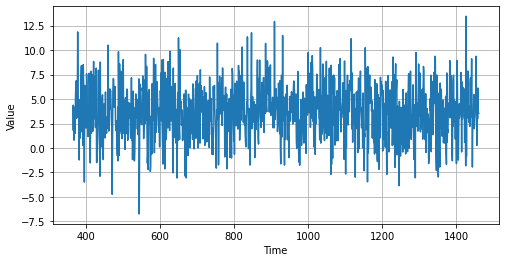

In [ ]:
#Remove trend and seasonality using Differing
diff_series = (series[365:] - series[:-365])# remove first 365, remove last 365
diff_time = time[365:]

plt.figure(figsize=(8,4))
plot_series(diff_time, diff_series)
plt.show()

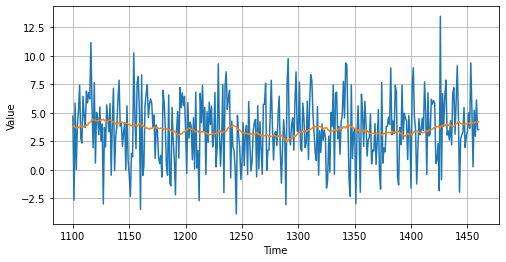

In [ ]:
#Add MA on differing
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:] 

plt.figure(figsize=(8,4))
plot_series(valid_time, diff_series[split_time - 365:]) 
plot_series(valid_time, diff_moving_avg)
plt.show()

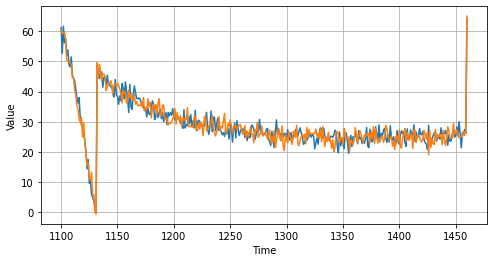


Mean Squared Error: 8.498155
Mean Absolute Error: 2.327179 



In [ ]:
#Add trend and seaonality back by adding the past values
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg 

plt.figure(figsize=(8,4))
plot_series(valid_time, valid_x)
plot_series(valid_time, diff_moving_avg_plus_past)
plt.show()

#MSE, MAE
print("\nMean Squared Error:", keras.metrics.mean_squared_error(valid_x, diff_moving_avg_plus_past).numpy())
print("Mean Absolute Error:", keras.metrics.mean_absolute_error(valid_x, diff_moving_avg_plus_past).numpy(),"\n")

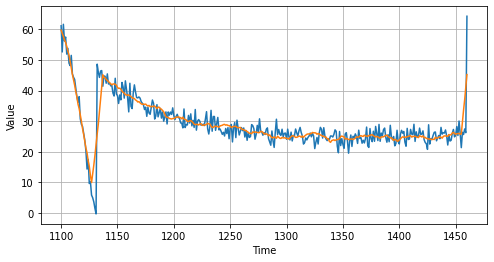


Mean Squared Error: 12.527958
Mean Absolute Error: 2.2034433 



In [ ]:
#Soothing the noisy
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg 

plt.figure(figsize=(8,4))
plot_series(valid_time, valid_x)
plot_series(valid_time, diff_moving_avg_plus_smooth_past)#
plt.show()

print("\nMean Squared Error:", keras.metrics.mean_squared_error(valid_x, diff_moving_avg_plus_smooth_past).numpy())
print("Mean Absolute Error:", keras.metrics.mean_absolute_error(valid_x, diff_moving_avg_plus_smooth_past).numpy(),"\n")

- What is an example of a univariate time series?
    - Hour by hour temperature.
- What is an example of a multivariate time series?
    - Hour by hour weather.
- What is imputed data?
    - A projection of unknown (usually past or missing) data.
- Is a sound wave a good example of time series data? Why?
    - Yes, because it contains multiple pieces of information across time. For example, a 44kHz soundwave has 44,000 pieces of information per second.
- What is autocorrelation?
    - Data that follows a predictable shape, even if the scale is different.
- What is a non-stationary time series?
    - One that has a disruptive event breaking trend and seasonality.